# Components Map-Making with other data

In this notebook, we leads to learn how to use more data than QUBIC ones to make a joint analysis. Here we benefit of the full sky coverage of Planck to correct edges effect of QUBIC reconstruction. We benefit also the spectral information for estimation of spectral indices, especially the HFI for the thermal dust and the LFI for the synchrotron emission.

In [1]:
from __future__ import division

# QUBIC packages
import qubic
from qubicpack.utilities import Qubic_DataDir
from qubic.data import PATH
from qubic.io import read_map
import Acquisition as Acq

# General packages
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pysm3
import warnings
import pysm3.units as u
from importlib import reload
from pysm3 import utils
from qubic import QubicSkySim as qss

# FG-Buster packages
import component_model as c
import mixing_matrix as mm

# PyOperators packages
from pyoperators import (
    BlockColumnOperator, BlockDiagonalOperator, BlockRowOperator,
    CompositionOperator, DiagonalOperator, I, IdentityOperator,
    MPIDistributionIdentityOperator, MPI, proxy_group, ReshapeOperator,
    rule_manager, pcg, Operator, DenseOperator)
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
warnings.filterwarnings("ignore")
%matplotlib inline

# %config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Here we define the number of sub-acquisitions and the number of pointing.

In [2]:
# Repository for dictionary
global_dir = '/pbs/home/m/mregnier/Libs/qubic/qubic/'#Qubic_DataDir()
print(global_dir)
dictfilename = global_dir + 'dicts/pipeline_demo.dict'

# Read dictionary chosen
d = qubic.qubicdict.qubicDict()
d.read_from_file(dictfilename)

from qubic import SpectroImLib as sp
from importlib import reload

Nf = 1
relative_bandwidth = 0.25
Nbfreq, nus_edge150, nus150, deltas, Delta, Nbbands = qubic.compute_freq(150, Nfreq=Nf)
Nbfreq, nus_edge220, nus220, deltas, Delta, Nbbands = qubic.compute_freq(220, Nfreq=Nf)
center = qubic.equ2gal(0, -57)
def give_dictionary(dictfilename, Nf, nside, pointing, band):
    d = qubic.qubicdict.qubicDict()
    d.read_from_file(dictfilename)
    d['nf_recon'] = Nf
    d['nf_sub'] = 1*Nf
    d['nside'] = nside
    npix=12*d['nside']**2
    d['RA_center'] = 0
    d['DEC_center'] = -57
    center = qubic.equ2gal(d['RA_center'], d['DEC_center'])
    d['effective_duration'] = 3
    #d['dtheta'] = 15
    d['npointings'] = pointing
    d['filter_nu'] = int(band*1e9)
    d['photon_noise'] = False
    d['config'] = 'FI'
    d['MultiBand'] = True
    
    return d

nside=256
pointing=2000

d150 = give_dictionary(dictfilename, Nf, nside, pointing, 150)
d220 = give_dictionary(dictfilename, Nf, nside, pointing, 220)

/pbs/home/m/mregnier/Libs/qubic/qubic/


In [3]:
nu0 = 150
skycmb = pysm3.Sky(nside=nside, preset_strings=['c1'])
skydust = pysm3.Sky(nside=nside, preset_strings=['d0'])
C =  HealpixConvolutionGaussianOperator(fwhm=np.deg2rad(0.39))

maps_dust = np.array(skydust.get_emission(nu0 * u.GHz, None) * utils.bandpass_unit_conversion(nu0 * u.GHz, None, u.uK_CMB).T)
maps_cmb = np.array(skycmb.get_emission(nu0 * u.GHz, None) * utils.bandpass_unit_conversion(nu0 * u.GHz, None, u.uK_CMB).T)
components = np.array([C(maps_cmb.T), C(maps_dust.T)])

C =  HealpixConvolutionGaussianOperator(fwhm=np.deg2rad(0.39))
print(C, maps_cmb.shape)
comp_for_pcg = np.array([C(maps_cmb.T), C(maps_dust.T)])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


healpixconvolutiongaussian (3, 786432)


In [4]:
reload(Acq)

# Pointing
p = qubic.get_pointing(d150)

# Scene
s = qubic.QubicScene(d150)

# Instrument
q150 = qubic.QubicMultibandInstrument(d150)
q220 = qubic.QubicMultibandInstrument(d220)

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.


Here, we instanciate the pipeline reconstruction as before but by giving others frequencies than QUBIC ones. Here, we consider only CMB + Dust, so we want to use the Planck HFI.

In [5]:
reload(Acq)

# QUBIC instruments
o150 = Acq.QubicIntegratedComponentsMapMaking(q150, p, s, d150, nus_edge150, comp=[c.CMB(), c.Dust(nu0=150, temp=20)])
o220 = Acq.QubicIntegratedComponentsMapMaking(q220, p, s, d220, nus_edge220, comp=[c.CMB(), c.Dust(nu0=150, temp=20)])

# QUBIC models
otwo = Acq.QubicTwoBandsComponentsMapMaking(o150, o220, s, [c.CMB(), c.Dust(nu0=150, temp=20)])
owide = Acq.QubicTwoBandsComponentsMapMaking(o150, o220, s, [c.CMB(), c.Dust(nu0=150, temp=20)])

cov = o150.get_coverage()
pixok = cov > 0


Pipeline = Acq.PipelineReconstruction(otwo, [143, 217, 353], comp=[c.CMB(), c.Dust(nu0=150, temp=20)], type='TwoBands', convolution=False)
H = Pipeline.get_operator(np.array([1.54]), type='no_convolution')
n = Pipeline.get_noise()
invN = Pipeline.get_invN()

tod = H(components)+n
A = H.T * invN * H
b = H.T * invN * tod

Info apcdhcp125.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp125.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
constant
Info apcdhcp125.in2p3.fr: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.
constant
nus  143
Constant index
nus  217
Constant index
nus  353
Constant index
In acquisition.py: self.forced_sigma=None
and self.sigma is:3.323401871576773e-17
Using theoretical TES noises
diagonal case
(1982016, 1982016)
905387052965142904678190040481792I
In acquisition.py: self.forced_sigma=None
and self.sigma is:3.323401871576773e-17
Using theoretical TES noises
diagonal case
(1982016, 1982016)
905387052965142904678190040481792I


Here we call the PCG as before.

In [6]:
M = Acq.get_preconditioner(np.ones(Pipeline.npix))

sol = pcg(A, b, x0=comp_for_pcg, tol=1e-4, M=M, disp=True)

   1: 0.001871122653185018
   2: 0.002429196095943429
   3: 0.0024653238151615127
   4: 0.002614432271035693
   5: 0.0016530661684128884
   6: 0.0013085101854290481
   7: 0.0014318631361449408
   8: 0.0014838057611122125
   9: 0.0013918236244951025
  10: 0.0014308253249642436
  11: 0.001371531121031478
  12: 0.0013801089124708724
  13: 0.0013786654344190368
  14: 0.0013140816034454739
  15: 0.0012646207184382851
  16: 0.0011856168045837974
  17: 0.001087348898019163
  18: 0.0009807624698555666
  19: 0.0008737719199011863
  20: 0.0008011473924638495
  21: 0.000752355685046727
  22: 0.0007091933560231438
  23: 0.000678988578140682
  24: 0.0008001704776482407
  25: 0.000854625842631343
  26: 0.0006542375050395832
  27: 0.0006521656862903622
  28: 0.0006619587529434694
  29: 0.0006680018466038497
  30: 0.0006773234191686457
  31: 0.000674165527409619
  32: 0.0006656847001239958
  33: 0.0006629083251923456
  34: 0.0006696743106047754
  35: 0.0007945323877753171
  36: 0.000733011820170244
  

In [7]:
outputs = sol['x'].copy()
inputs = components.copy()
#inputs[:, ~pixok, :] = hp.UNSEEN

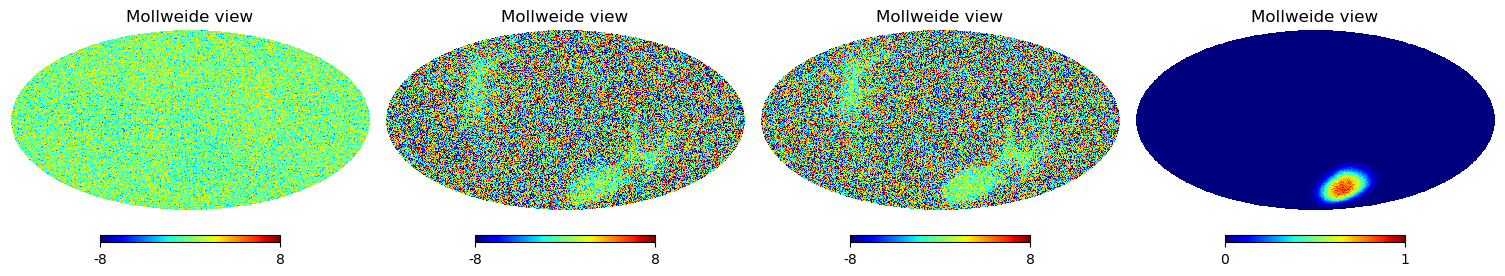

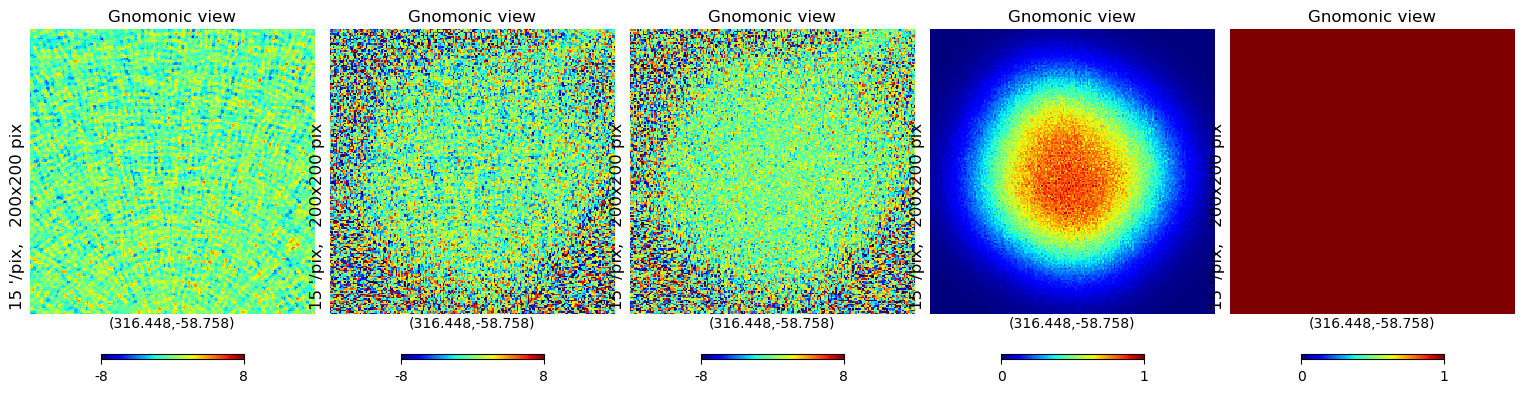

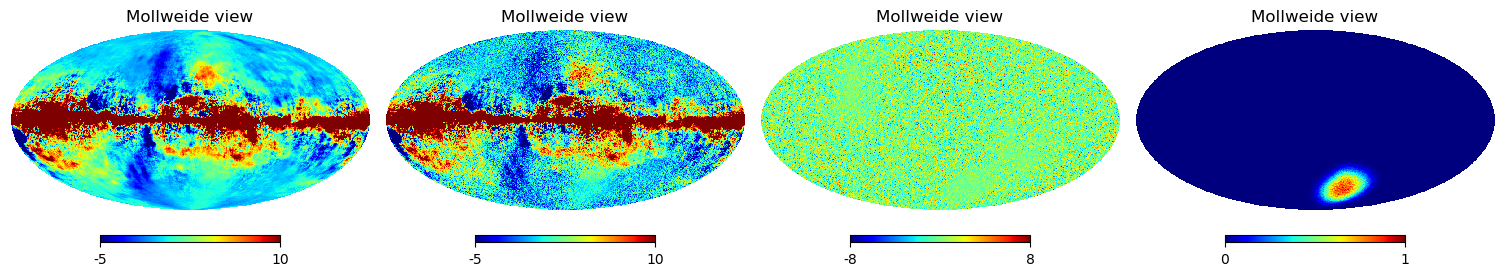

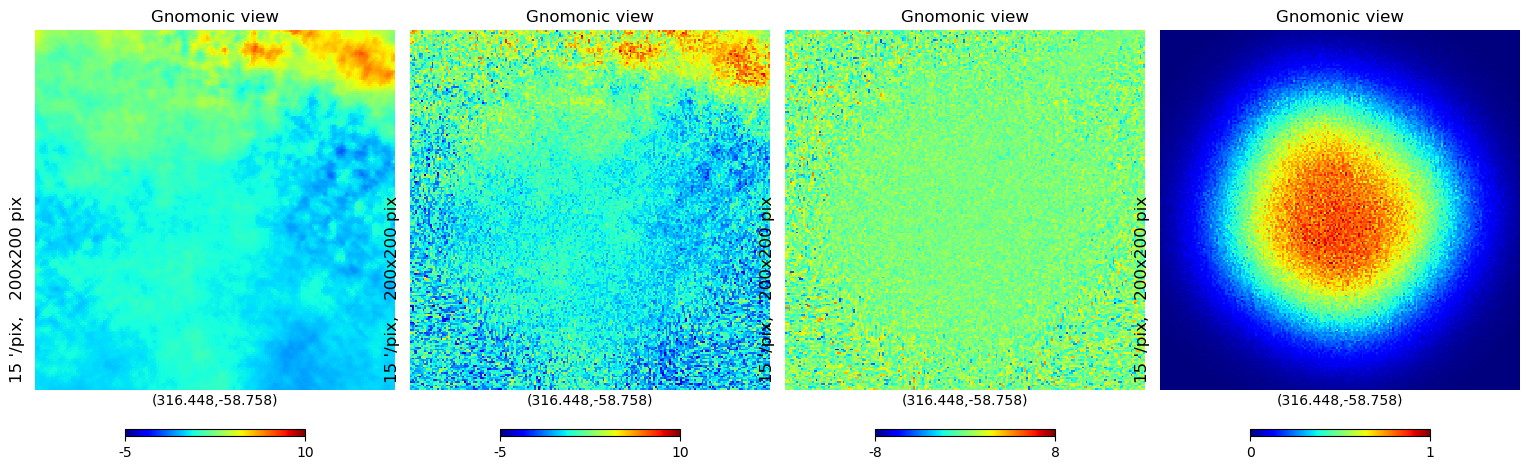

In [8]:
r = 8
rr = 8
reso= 15
istk = 1

plt.figure(figsize=(15, 5))
hp.mollview(inputs[0, :, istk], cmap='jet', min=-rr, max=rr, sub=(1, 4, 1))
hp.mollview(outputs[0, :, istk], cmap='jet', min=-rr, max=rr, sub=(1, 4, 2))
hp.mollview(inputs[0, :, istk] - outputs[0, :, istk], cmap='jet', min=-r, max=r, sub=(1, 4, 3))
hp.mollview(cov/cov.max(), cmap='jet', min=0, max=1, sub=(1, 4, 4))
plt.show()

plt.figure(figsize=(15, 5))
hp.gnomview(inputs[0, :, istk], cmap='jet', min=-rr, max=rr, sub=(1, 5, 1), rot=center, reso=reso)
hp.gnomview(outputs[0, :, istk], cmap='jet', min=-rr, max=rr, sub=(1, 5, 2), rot=center, reso=reso)
hp.gnomview(inputs[0, :, istk] - outputs[0, :, istk], cmap='jet', min=-r, max=r, sub=(1, 5, 3), rot=center, reso=reso)
hp.gnomview(cov/cov.max(), cmap='jet', min=0, max=1, sub=(1, 5, 4), rot=center, reso=reso)
hp.gnomview(pixok, cmap='jet', min=0, max=1, sub=(1, 5, 5), rot=center, reso=reso)
plt.show()


plt.figure(figsize=(15, 5))
hp.mollview(inputs[1, :, istk], cmap='jet', min=-5, max=10, sub=(1, 4, 1))
hp.mollview(outputs[1, :, istk], cmap='jet', min=-5, max=10, sub=(1, 4, 2))
hp.mollview(inputs[1, :, istk] - outputs[1, :, istk], cmap='jet', min=-r, max=r, sub=(1, 4, 3))
hp.mollview(cov/cov.max(), cmap='jet', min=0, max=1, sub=(1, 4, 4))
plt.show()

plt.figure(figsize=(15, 5))
hp.gnomview(inputs[1, :, istk], cmap='jet', min=-5, max=10, sub=(1, 4, 1), rot=center, reso=reso)
hp.gnomview(outputs[1, :, istk], cmap='jet', min=-5, max=10, sub=(1, 4, 2), rot=center, reso=reso)
hp.gnomview(inputs[1, :, istk] - outputs[1, :, istk], cmap='jet', min=-r, max=r, sub=(1, 4, 3), rot=center, reso=reso)
hp.gnomview(cov/cov.max(), cmap='jet', min=0, max=1, sub=(1, 4, 4), rot=center, reso=reso)
plt.show()